In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from keras.models import load_model
from os.path import join
from bridgescaler import load_scaler
from sealsml.data import Preprocessor
%matplotlib inline

2024-06-26 15:54:31.876121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 15:54:32.707643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
ls /glade/derecho/scratch/dgagne/SEALS_TRAINING/TEST_TRANSFORMER/2024-06-26_1541/

block_transformer_leak_loc_2024-06-26_1541.keras
block_transformer_leak_loc_model_hist_2024-06-26_1541.csv
block_transformer_leak_loc_output_2024-06-26_1541_train.nc
block_transformer_leak_loc_output_2024-06-26_1541_val.nc
coord_scaler.json
sensor_scaler.json
train_files.csv
train.yml
validation_files.csv


In [2]:
model_path = "/glade/derecho/scratch/dgagne/SEALS_TRAINING/TEST_TRANSFORMER/2024-06-26_1541/"

In [3]:
mod = load_model(join(model_path, "block_transformer_leak_loc_2024-06-26_1541.keras"))

2024-06-26 15:54:46.000970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38374 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0


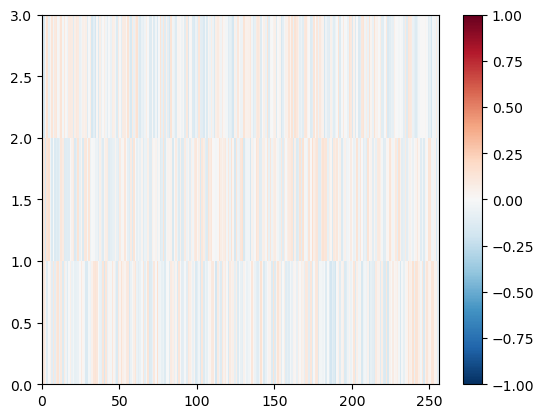

In [13]:
plt.pcolormesh(mod.decoder_hidden.get_weights()[0], cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar()

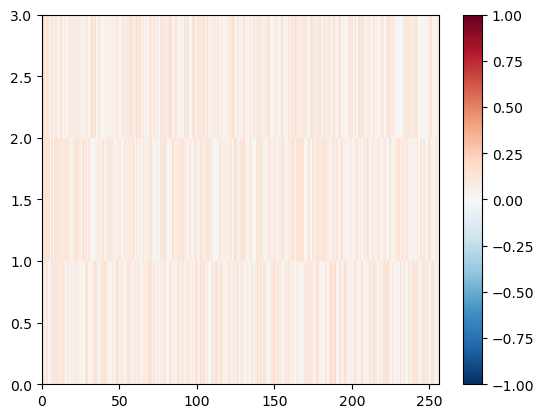

In [14]:
plt.pcolormesh(np.abs(mod.decoder_hidden.get_weights()[0]), cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar()

In [19]:
mod.time_block_sensor_encoder.dense_embedding

<Dense name=tb_embedding, built=True>

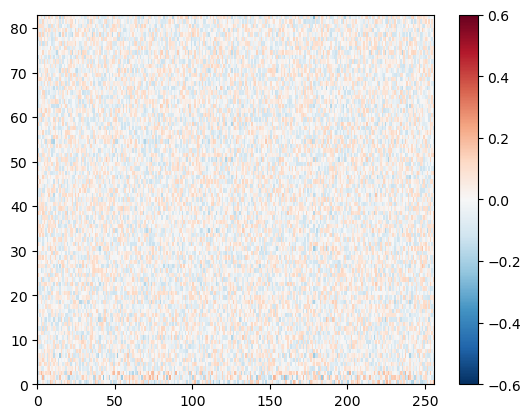

In [20]:
plt.pcolormesh(mod.time_block_sensor_encoder.dense_embedding.get_weights()[0], cmap="RdBu_r", vmin=-0.6, vmax=0.6)
plt.colorbar()

In [69]:
mod.encoder_hidden.get_weights()[0].shape

(560, 128)

In [21]:
mod.n_conv_layers

3

In [4]:
val_ds = xr.open_dataset(join(model_path, "block_transformer_leak_loc_output_2024-06-26_1541_val.nc"))

In [72]:
val_ds

<xarray.Dataset> Size: 101MB
Dimensions:        (sample: 221184, pot_leak_locs: 38)
Dimensions without coordinates: sample, pot_leak_locs
Data variables:
    targets        (sample, pot_leak_locs) int64 67MB ...
    leak_loc_pred  (sample, pot_leak_locs) float32 34MB ...

In [4]:
val_files = pd.read_csv(join(model_path, "validation_files.csv"))

In [78]:
val_files

,Unnamed: 0,validation_files
0,0,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
1,1,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
2,2,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
3,3,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
4,4,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
...,...,...
187,187,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
188,188,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
189,189,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
190,190,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...


In [6]:
val_file_ds = xr.open_dataset(val_files["validation_files"][0])

In [7]:
val_file_ds["decoder_input"][1, :, 0, :4, 0]

<xarray.DataArray 'decoder_input' (pot_leak: 38, variable: 4)> Size: 608B
[152 values with dtype=float32]
Coordinates:
  * variable  (variable) <U12 192B 'ref_distance' 'ref_azi_sin' ... 'ref_elv'
Dimensions without coordinates: pot_leak

In [11]:
p = Preprocessor()
encoder_data, decoder_data, leak_location, leak_rate = p.load_data(val_files["validation_files"][0:4])
p.load_scalers(join(model_path, "sensor_scaler.json"), join(model_path, "coord_scaler.json"))
scaled_encoder_data, scaled_decoder_data, encoder_mask, decoder_mask = p.preprocess(encoder_data, decoder_data, fit_scaler=False)


In [128]:
decoder_data

<xarray.DataArray 'decoder_input' (sample: 3456, pot_leak: 38, target_time: 1,
                                   variable: 8, mask: 2)> Size: 8MB
dask.array<concatenate, shape=(3456, 38, 1, 8, 2), dtype=float32, chunksize=(1152, 38, 1, 8, 2), chunktype=numpy.ndarray>
Coordinates:
  * variable  (variable) <U12 384B 'ref_distance' 'ref_azi_sin' ... 'w' 'q_CH4'
Dimensions without coordinates: sample, pot_leak, target_time, mask

In [12]:
preds = mod.predict((scaled_encoder_data, scaled_decoder_data))

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [13]:
preds_shuffled_set = []
for v in range(4):
    print(v)
    scaled_decoder_shuffled = np.copy(scaled_decoder_data)
    rng = np.random.default_rng()
    rng.shuffle(scaled_decoder_shuffled[:, :, v], axis=0)
    preds_shuffled = mod.predict((scaled_encoder_data, scaled_decoder_shuffled), batch_size=2048)
    preds_shuffled_set.append(preds_shuffled)

0


I0000 00:00:1719440956.631579   56524 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10', 56 bytes spill stores, 56 bytes spill loads

I0000 00:00:1719440960.087760   56523 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_16', 56 bytes spill stores, 56 bytes spill loads

I0000 00:00:1719440961.607983   56522 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 56 bytes spill stores, 56 bytes spill loads



1/2 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step

I0000 00:00:1719440969.874558   56624 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_16', 56 bytes spill stores, 56 bytes spill loads

I0000 00:00:1719440972.369477   56624 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 56 bytes spill stores, 56 bytes spill loads

I0000 00:00:1719440974.902885   56624 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10', 56 bytes spill stores, 56 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 14s/step
1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [14]:
decoder_pred_diffs = np.zeros(4)
for v in range(4):
    decoder_pred_diffs[v] = np.sqrt(np.mean((preds - preds_shuffled_set[v]) ** 2))
    print(decoder_data["variable"][v].values, decoder_pred_diffs[v])
    

ref_distance 0.008392088115215302
ref_azi_sin 0.05274413526058197
ref_azi_cos 0.07094971090555191
ref_elv 6.0449154261732474e-05


In [15]:
preds_shuffled_enc = []
for v in range(8):
    print(v)
    scaled_encoder_shuffled = np.copy(scaled_encoder_data)
    rng = np.random.default_rng()
    rng.shuffle(scaled_encoder_shuffled[:, :, :, v], axis=0)
    preds_shuffled = mod.predict((scaled_encoder_shuffled, scaled_decoder_data), batch_size=2048)
    preds_shuffled_enc.append(preds_shuffled)

0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [16]:
encoder_pred_diffs = np.zeros(8)
for v in range(8):
    encoder_pred_diffs[v] = np.sqrt(np.mean((preds - preds_shuffled_enc[v]) ** 2))
    print(encoder_data["variable"][v].values, encoder_pred_diffs[v])

ref_distance 0.0010069748386740685
ref_azi_sin 0.025498447939753532
ref_azi_cos 0.03564561903476715
ref_elv 6.0449154261732474e-05
u 6.907925853738561e-05
v 0.010775342583656311
w 0.005194913130253553
q_CH4 0.00018773230840452015


(array([ 224100.,  245100.,  226800.,  225600.,  223800.,  230700.,
         241500.,  226200.,  237000.,  234600.,  225000.,  236400.,
         238800.,  244200.,  231900.,  234900.,  243300.,  179700.,
              0., 1034400.]),
 array([5.00500493e-04, 4.55205217e-02, 9.05405432e-02, 1.35560557e-01,
        1.80580586e-01, 2.25600600e-01, 2.70620614e-01, 3.15640628e-01,
        3.60660672e-01, 4.05680686e-01, 4.50700700e-01, 4.95720714e-01,
        5.40740728e-01, 5.85760772e-01, 6.30780756e-01, 6.75800800e-01,
        7.20820844e-01, 7.65840828e-01, 8.10860872e-01, 8.55880857e-01,
        9.00900900e-01]),
 <BarContainer object of 20 artists>)

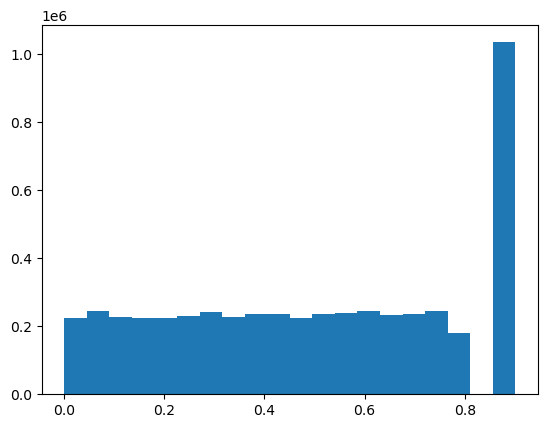

In [195]:
plt.hist(scaled_encoder_data[:, :, :, 2].ravel(), bins=20)

In [186]:
scaled_encoder_data.shape

(3456, 5, 300, 8)

(array([215., 301., 300., 296., 334., 382., 398., 401., 550., 279.]),
 array([-0.39802709, -0.32535496, -0.25268283, -0.18001069, -0.10733856,
        -0.03466643,  0.0380057 ,  0.11067783,  0.18334997,  0.2560221 ,
         0.32869422]),
 <BarContainer object of 10 artists>)

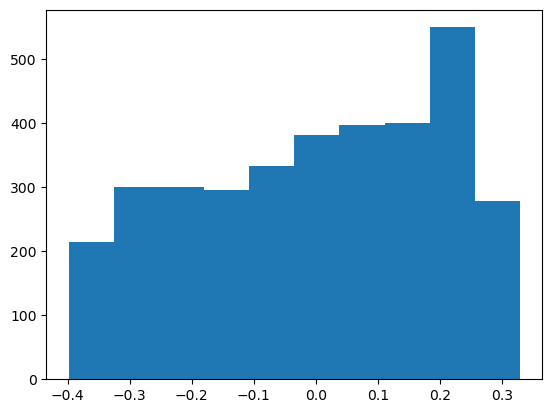

In [168]:
plt.hist(scaled_decoder_data[:, :, 0][leak_location == 1] - scaled_decoder_data[:, :, 0].mean(axis=1))


In [176]:
pdp_inputs = np.arange(0, 1.05, 0.05)
pdp_vals = np.zeros(pdp_inputs.shape)
for p, pdpi in enumerate(pdp_inputs):
    print(p)
    scaled_decoder_data_pdp = np.copy(scaled_decoder_data)
    scaled_decoder_data_pdp[:, :, 3] = pdpi
    pdp_preds = mod.predict((scaled_encoder_data, scaled_decoder_data_pdp), batch_size=1024)
    pdp_vals[p] = pdp_preds.mean()

0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
12
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
14
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
16
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
18
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


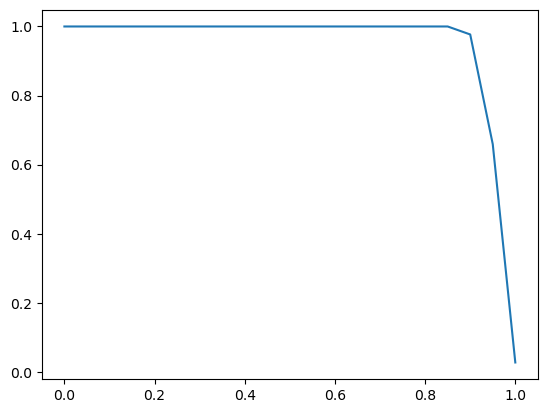

In [177]:
plt.plot(pdp_inputs, pdp_vals)